Total samples: 9418, Training samples: 7534, Validation samples: 942, Test samples: 942


Epoch 1/20
235/235 [==============================] - 665s 3s/step - loss: 0.5786 - accuracy: 0.7725 - val_loss: 0.5406 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 608s 3s/step - loss: 0.5308 - accuracy: 0.7838 - val_loss: 0.5393 - val_accuracy: 0.7681 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 586s 2s/step - loss: 0.5294 - accuracy: 0.7841 - val_loss: 0.5330 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 549s 2s/step - loss: 0.5272 - accuracy: 0.7835 - val_loss: 0.5358 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 1159s 5s/step - loss: 0.5262 - accuracy: 0.7834 - val_loss: 0.5310 - val_accuracy: 0.7736 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 1538s 7s/step - loss: 0.5273 - accuracy: 0.7837 - val_loss: 0.5380 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 7/20
235/235 [==============================] - 1456s 6s

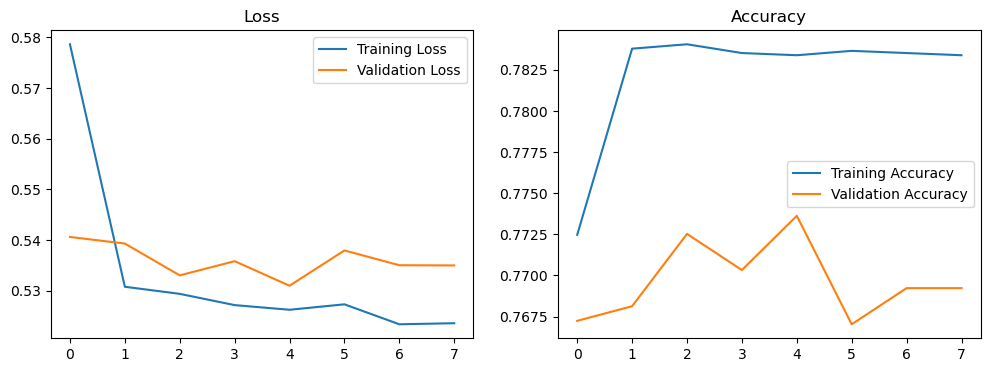

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50  # Import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def image_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = [prepare_image(path) for path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

def prepare_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Adjust target_size for ResNet
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

X = []
Y = []

# Real images from CASIA2
real_path_casia2 = "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA2\\Au\\"
for dirname, _, filenames in os.walk(real_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(1)

# Fake images from CASIA2
fake_path_casia2 = "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA2\\Tp\\"
for dirname, _, filenames in os.walk(fake_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(0)

# Convert labels to categorical
Y = to_categorical(Y, 2)

# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f'Total samples: {len(X)}, Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}')

# Create ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator for training data
train_data_generator = image_generator(X_train, Y_train, batch_size=32)

# Generator for validation data
val_data_generator = image_generator(X_val, Y_val, batch_size=32)

# Generator for test data
test_data_generator = image_generator(X_test, Y_test, batch_size=32)

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True
                               )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.2,
                                       patience=3,
                                       verbose=1,
                                       min_delta=0.0001)

callbacks_list = [early_stopping, reduce_learningrate]

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_data_generator,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_list
)

# Evaluate the model on the test set
test_score = model.evaluate(test_data_generator, steps=len(X_test) // 32, verbose=0)
print(f'Test loss: {test_score[0]}, Test accuracy: {test_score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluate the model on the test set
test_score = model.evaluate(test_data_generator, steps=len(X_test) // 32, verbose=0)
print(f'Test loss: {test_score[0]}, Test accuracy: {test_score[1]}')

# Predictions on training data
train_predictions = model.predict(train_data_generator, steps=len(X_train) // 32)

# Calculate precision, recall, and F1-score for training data
train_predictions_classes = np.argmax(train_predictions, axis=1)
train_true_classes = np.argmax(Y_train, axis=1)

precision = precision_score(train_true_classes, train_predictions_classes)
recall = recall_score(train_true_classes, train_predictions_classes)
f1 = f1_score(train_true_classes, train_predictions_classes)

print(f'Training Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

Test loss: 0.5330828428268433, Test accuracy: 0.7725274562835693
235/235 [==============================] - 577s 2s/step


ValueError: Found input variables with inconsistent numbers of samples: [7534, 7502]

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# # Train the model using the generators
# history = model.fit(
#     train_data_generator,
#     steps_per_epoch=len(X_train) // 32,
#     epochs=20,
#     validation_data=val_data_generator,
#     validation_steps=len(X_val) // 32,
#     callbacks=callbacks_list
# )

# Evaluate the model on the test set
test_score = model.evaluate(test_data_generator, steps=len(X_test) // 32, verbose=0)
print(f'Test loss: {test_score[0]}, Test accuracy: {test_score[1]}')

# Predictions on training data
train_predictions = model.predict(train_data_generator, steps=len(X_train) // 32)

# Ensure the number of samples matches
train_true_classes = np.argmax(Y_train[:len(train_predictions)], axis=1)

# Calculate precision, recall, and F1-score for training data
precision = precision_score(train_true_classes, train_predictions_classes)
recall = recall_score(train_true_classes, train_predictions_classes)
f1 = f1_score(train_true_classes, train_predictions_classes)

print(f'Training Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

# Generate predictions on the validation set
val_steps = len(X_val) // 32
val_predictions = model.predict(val_data_generator, steps=val_steps, verbose=0)
val_predictions = np.argmax(val_predictions, axis=1)

# Ensure Y_val_categorical and val_predictions have the same length
Y_val_categorical = Y_val[:len(val_predictions)]

# Compute and print classification report
print("Classification Report:")
print(classification_report(Y_val_categorical, val_predictions))

# Compute and print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(Y_val_categorical, val_predictions)
print(conf_matrix)


Test loss: 0.5383747220039368, Test accuracy: 0.7681318521499634
235/235 [==============================] - 574s 2s/step
Training Precision: 0.7832577979205545, Recall: 1.0, F1-Score: 0.8784571684855734
Classification Report:


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets